# Basic of MLOps

**MLflow Tutorial: Experiment Tracking and Model Registry**

**1. MLflow Installation and Setup**

Install MLflow and dependencies

```
pip install mlflow
pip install docker
pip install hyperopt
pip install xgboost
```

Start MLflow UI (run in terminal)

```
mlflow ui --host 0.0.0.0 --port 5000
```

In [ ]:
!pip install mlflow
!pip install hyperopt
!pip install xgboost

: 

2. Docker Setup for MLflow Tracking Server

Create a Dockerfile
```
FROM python:3.8
RUN pip install mlflow
EXPOSE 5000
CMD mlflow server \
    --host 0.0.0.0 \
    --port 5000 \
    --backend-store-uri postgresql://user:password@db:5432/mlflow \
    --default-artifact-root s3://your-bucket/
```
Build and run
```
docker build -t mlflow-server .
docker run -p 5000:5000 mlflow-server
```

In [ ]:
#Import libraries
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

: 

3. Basic Experiment Tracking

2024/11/19 19:52:50 INFO mlflow.tracking.fluent: Experiment with name 'regression_experiment' does not exist. Creating a new experiment.


2024/11/19 19:52:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


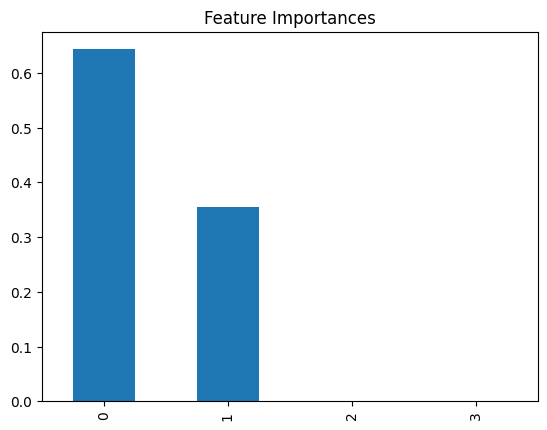

In [4]:
# 3. Basic Experiment Tracking
def load_data():
    # Sample data generation
    np.random.seed(42)
    X = np.random.rand(1000, 4)
    y = X[:, 0] * 2 + X[:, 1] * 1.5 + np.random.rand(1000) * 0.1
    return train_test_split(X, y, test_size=0.2)

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2

# Start MLflow experiment
mlflow.set_experiment("regression_experiment")

X_train, X_test, y_train, y_test = load_data()

with mlflow.start_run():
    # Train RandomForest model
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_train, y_train)
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    
    # Evaluate and log metrics
    mse, r2 = evaluate_model(rf_model, X_test, y_test)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    # Log feature importance plot
    plt.figure()
    feat_imp = pd.Series(rf_model.feature_importances_)
    feat_imp.plot(kind='bar')
    plt.title("Feature Importances")
    mlflow.log_figure(plt.gcf(), "feature_importance.png")

4. XGBoost Integration

In [5]:
# 4. XGBoost Integration
def train_xgboost():
    with mlflow.start_run(nested=True):
        # Create DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # XGBoost parameters
        params = {
            "objective": "reg:squarederror",
            "max_depth": 6,
            "learning_rate": 0.1
        }
        
        # Train model
        model = xgb.train(params, dtrain, num_boost_round=100)
        
        # Log parameters and model
        mlflow.log_params(params)
        mlflow.xgboost.log_model(model, "xgboost_model")
        
        # Evaluate
        predictions = model.predict(dtest)
        mse = mean_squared_error(y_test, predictions)
        mlflow.log_metric("mse", mse)

5. Hyperparameter Optimization

In [6]:
# 5. Hyperparameter Optimization
def objective(params):
    with mlflow.start_run(nested=True):
        rf_model = RandomForestRegressor(**params)
        rf_model.fit(X_train, y_train)
        mse, _ = evaluate_model(rf_model, X_test, y_test)
        
        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        
        return {"loss": mse, "status": STATUS_OK}

space = {
    "n_estimators": hp.choice("n_estimators", range(10, 100)),
    "max_depth": hp.choice("max_depth", range(1, 20)),
    "min_samples_split": hp.choice("min_samples_split", range(2, 10))
}

# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
           space=space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials)

100%|██████████| 50/50 [00:06<00:00,  7.63trial/s, best loss: 0.0021698771748955544]


6. Model Registry

In [7]:
# 6. Model Registry
def register_best_model():
    # Get best run
    best_run = mlflow.search_runs(
        experiment_ids=[mlflow.get_experiment_by_name("regression_experiment").experiment_id],
        order_by=["metrics.mse ASC"]
    ).iloc[0]
    
    # Register model
    model_uri = f"runs:/{best_run.run_id}/random_forest_model"
    mv = mlflow.register_model(model_uri, "RandomForestRegressor")
    
    # Transition to Production
    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(
        name="RandomForestRegressor",
        version=mv.version,
        stage="Production"
    )

7. Custom Metrics


In [8]:
# 7. Custom Metrics
def custom_metric(y_true, y_pred):
    """Custom metric example: weighted MSE"""
    weights = np.exp(-np.abs(y_true))
    weighted_mse = np.mean(weights * (y_true - y_pred) ** 2)
    return weighted_mse

# Log custom metric
with mlflow.start_run():
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    
    custom_score = custom_metric(y_test, predictions)
    mlflow.log_metric("weighted_mse", custom_score)

8. Loading Models from Registry

In [9]:
# 8. Loading Models from Registry
def load_production_model():
    model = mlflow.pyfunc.load_model(
        model_uri=f"models:/RandomForestRegressor/Production"
    )
    return model

9. Example usage

In [10]:
# Example usage
if __name__ == "__main__":
    # Run basic experiment
    with mlflow.start_run(run_name="full_experiment"):
        # Train and log RandomForest
        print("Training RandomForest...")
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)
        mse, r2 = evaluate_model(rf_model, X_test, y_test)
        
        mlflow.log_params({
            "model_type": "RandomForest",
            "n_estimators": rf_model.n_estimators
        })
        mlflow.log_metrics({
            "mse": mse,
            "r2": r2
        })
        
        # Train XGBoost
        print("Training XGBoost...")
        train_xgboost()
        
        # Run hyperparameter optimization
        print("Optimizing hyperparameters...")
        best_params = fmin(fn=objective,
                         space=space,
                         algo=tpe.suggest,
                         max_evals=10,
                         trials=trials)
        
        # Register best model
        print("Registering best model...")
        register_best_model()

Training RandomForest...
Training XGBoost...


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/11/19 19:53:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimizing hyperparameters...
50trial [00:00, ?trial/s, best loss=?]
Registering best model...


Successfully registered model 'RandomForestRegressor'.
Created version '1' of model 'RandomForestRegressor'.
/tmp/ipykernel_21688/1728834432.py:15: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
